In [81]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


In [116]:
# Define the FireDataset class
class FireDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_paths = glob(os.path.join(images_dir, '*.jpg'))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        width, height = image.size


        
        # Load corresponding label in YOLO format
        label_path = os.path.join(self.labels_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
        bboxes = []
        
        with open(label_path, 'r') as f:
            for line in f:
                # Assuming YOLO format `class_id x_center y_center width height`
                class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())
                
                # # Convert YOLO format to corner format
                # x_min = (x_center - box_width / 2) * 640
                # y_min = (y_center - box_height / 2) * 640
                # x_max = (x_center + box_width / 2) * 640
                # y_max = (y_center + box_height / 2) * 640
                
                # Append converted coordinates
                bboxes.append([class_id, x_center, y_center, box_width, box_height])
        
        # Convert bounding boxes to tensor
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, bboxes

# Define transformation to resize all images to a consistent size
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize all images to 640x640
    transforms.ToTensor()
])

# Instantiate the dataset
train_images_dir = 'datasets/D-Fire/train/images'
train_labels_dir = 'datasets/D-Fire/train/labels'
test_images_dir = 'datasets/D-Fire/test/images'
test_labels_dir = 'datasets/D-Fire/test/labels'
train_dataset = FireDataset(train_images_dir, train_labels_dir, transform=transform)
test_dataset = FireDataset(test_images_dir, test_labels_dir, transform=transform)

# Custom collate function to handle varying image sizes (already resized to 640x640)
def collate_fn(batch):
    images, bboxes = zip(*batch)
    # Stack images and bounding boxes
    images = torch.stack(images)
    return images, bboxes

# Create DataLoader with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)


In [96]:
# Test DataLoader
def show_image_with_bboxes(image, bboxes):
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    
    for bbox in bboxes:
        # class_id, x_min, y_min, x_max, y_max = bbox
        class_id, x_center, y_center, box_width, box_height = bbox
        # Convert YOLO format to corner format
        x_min = (x_center - box_width / 2) * 640
        y_min = (y_center - box_height / 2) * 640
        x_max = (x_center + box_width / 2) * 640
        y_max = (y_center + box_height / 2) * 640

        if class_id == 0:
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          linewidth=2, edgecolor='blue', facecolor='none'))
        else:
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                          linewidth=2, edgecolor='red', facecolor='none'))
    plt.axis('off')
    plt.show()

In [97]:
print("Total number of images in the training dataset:", len(train_dataset))
print("Total number of batches in train_loader:", len(train_loader))
print("Total number of images in 1 batch: ", (len(train_dataset)/len(train_loader)))
print("\n")
print("Total number of images in the testing dataset:", len(test_dataset))
print("Total number of batches in test_loader:", len(test_loader))
print("Total number of images in 1 batch: ", (len(test_dataset)/len(test_loader)))


Total number of images in the training dataset: 17221
Total number of batches in train_loader: 2153
Total number of images in 1 batch:  7.998606595448212


Total number of images in the testing dataset: 4306
Total number of batches in test_loader: 539
Total number of images in 1 batch:  7.98886827458256


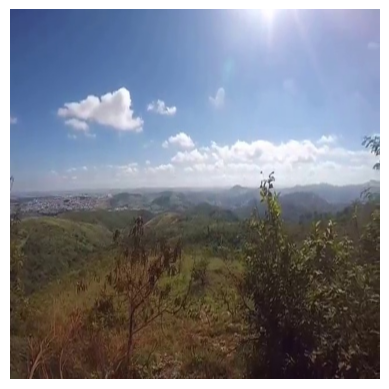

0


In [107]:
from random import randint

n = randint(0, len(train_dataset))
image, label = train_dataset[n]
show_image_with_bboxes(image, label)
print(len(label))

In [92]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.model.train()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [109]:
from ultralytics import YOLO
import torch

# Load a YOLO model (e.g., YOLOv8 Nano) and set device
model = YOLO('yolov8n.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)
num_epochs = 50

# Training loop with custom data loader
for epoch in range(num_epochs):
    model.model.train()
    total_loss = 0
    
    for images, bboxes in train_loader:
        images = images.to(device)
        
        # Prepare labels in YOLOv8-compatible format
        # Each label is expected as: [class_id, x_center, y_center, width, height]
        # Stack class_ids with bounding boxes into a single tensor
        yolo_targets = []
        if len(bboxes)>0:
            for i, bbox in enumerate(bboxes):
                img_bboxes = []
                for box in bbox:
                    class_id, x_center, y_center, box_width, box_height = box.tolist()
                    img_bboxes.append([class_id, x_center, y_center, box_width, box_height])
                yolo_targets.append(torch.tensor(img_bboxes, dtype=torch.float32).to(device))
        else:
            class_id, x_center, y_center, box_width, box_height = [2, -1, -1, -1, -1]
            yolo_targets.append(torch.tensor(img_bboxes, dtype=torch.float32).to(device))

        # Forward pass and calculate loss (YOLO handles loss internally during forward pass)
        optimizer.zero_grad()
        preds = model.model(images, augment=False)  # Forward pass with no augmentations
        loss = model.model.loss(preds, yolo_targets)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    # Optional validation step here


RuntimeError: cannot reshape tensor of 0 elements into shape [0, 144, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [112]:
from ultralytics import YOLO

# Load a YOLOv8 model
model = YOLO('yolov8n.pt')

# Train the model with a fixed image size (e.g., 640x640)
model.train(
    data='data.yaml',
    epochs=50,
    imgsz=1024,  # Fixed image size
    batch=8,
    name='fire_detection'
)


Ultralytics 8.3.29 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=fire_detection6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /media/chaos/New Volume/CV/datasets/D-Fire/train/labels.cache... 17221 images, 7833 backgrounds, 0 corrupt: 100%|██████████| 17221/17221 [00:00<?, ?it/s]

train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB02521.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB06626.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07199.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07271.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07278.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07297.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07305.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/train/images/WEB07312.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /media/chaos/New Volum


val: Scanning /media/chaos/New Volume/CV/datasets/D-Fire/test/labels.cache... 4306 images, 2005 backgrounds, 8 corrupt: 100%|██████████| 4306/4306 [00:00<?, ?it/s]

val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0078125]
val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB10821.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.009375]
val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB11090.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0027778]
val: WARNING ⚠️ /media/chaos/New Volume/CV/datasets/D-Fire/test/images/WEB11243.jpg: corrupt JPEG restored and saved
val: WARNING ⚠️ /media/chaos/N

Plotting labels to runs/detect/fire_detection6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/fire_detection6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.81G      1.684      3.691      1.723          4       1024: 100%|██████████| 2153/2153 [07:59<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:34<00:00,  7.79it/s]


                   all       4298       5176      0.445        0.4       0.37      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.84G      1.684      2.266      1.699          9       1024: 100%|██████████| 2153/2153 [07:45<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:31<00:00,  8.42it/s]


                   all       4298       5176      0.498      0.435      0.424       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.82G      1.756      2.118      1.778          6       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.77it/s]


                   all       4298       5176       0.42      0.385      0.341      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.89G      1.783      2.102      1.813         20       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.72it/s]


                   all       4298       5176      0.485      0.445      0.429      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.81G      1.733      1.975      1.767         17       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.72it/s]


                   all       4298       5176      0.515      0.488      0.487      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.86G      1.693      1.852      1.735         22       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.72it/s]


                   all       4298       5176      0.534      0.518      0.521      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.81G      1.654      1.805      1.708         19       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.75it/s]


                   all       4298       5176      0.562       0.52      0.543      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.89G      1.632      1.745       1.69         11       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.70it/s]


                   all       4298       5176      0.586       0.55      0.574      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.85G      1.613      1.686      1.676          6       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.74it/s]


                   all       4298       5176      0.616      0.572      0.607      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.83G      1.589      1.633      1.657         15       1024: 100%|██████████| 2153/2153 [07:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.68it/s]


                   all       4298       5176      0.607      0.581      0.605      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.96G       1.56      1.599      1.636         10       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.80it/s]


                   all       4298       5176      0.637      0.587      0.626      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.83G      1.555      1.562      1.631          6       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.78it/s]


                   all       4298       5176      0.602        0.6      0.622      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G      1.547       1.55      1.619          9       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:31<00:00,  8.64it/s]


                   all       4298       5176       0.64      0.603      0.655      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.8G      1.533       1.51      1.611         15       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.70it/s]


                   all       4298       5176      0.652      0.618      0.662      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.85G      1.517       1.49      1.597          8       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.76it/s]


                   all       4298       5176      0.656      0.625      0.668      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.91G      1.509      1.474      1.587         25       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.87it/s]


                   all       4298       5176      0.659       0.63      0.676      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.8G      1.507       1.45      1.583          8       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.84it/s]


                   all       4298       5176      0.665      0.634      0.682      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.8G      1.498      1.444      1.579         11       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.84it/s]


                   all       4298       5176      0.673       0.64      0.689       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.85G      1.483      1.413      1.573         12       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:31<00:00,  8.67it/s]


                   all       4298       5176      0.676       0.65      0.701      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.8G       1.47      1.391      1.566          5       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.82it/s]


                   all       4298       5176      0.692      0.643      0.708      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.83G      1.466      1.367      1.551          5       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.82it/s]


                   all       4298       5176      0.689      0.652      0.714      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.8G      1.452       1.36      1.548          5       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.72it/s]


                   all       4298       5176      0.707      0.648      0.719      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.82G      1.449      1.345       1.54         11       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.85it/s]


                   all       4298       5176      0.696      0.671      0.725      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.99G      1.444      1.327      1.528         19       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.90it/s]


                   all       4298       5176      0.708       0.67       0.73      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.8G      1.434      1.304       1.52          4       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.81it/s]


                   all       4298       5176      0.702      0.677       0.73      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.82G      1.429      1.309      1.522         16       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.88it/s]


                   all       4298       5176      0.721      0.675      0.739       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.85G      1.426      1.295      1.516         16       1024: 100%|██████████| 2153/2153 [07:39<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.74it/s]


                   all       4298       5176      0.722      0.668      0.739      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.82G      1.414      1.277       1.51          7       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.77it/s]


                   all       4298       5176      0.728      0.683      0.744      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.86G      1.406       1.25      1.495         18       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.84it/s]


                   all       4298       5176      0.728      0.675      0.745      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.82G      1.392      1.247      1.491          7       1024: 100%|██████████| 2153/2153 [07:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.86it/s]


                   all       4298       5176      0.732       0.68      0.748      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.83G      1.392      1.235      1.489         10       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.89it/s]


                   all       4298       5176      0.725      0.686      0.749      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.8G      1.386      1.206      1.478         17       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.72it/s]


                   all       4298       5176      0.734      0.684      0.754      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.82G       1.37      1.208      1.478         12       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.81it/s]

                   all       4298       5176       0.73      0.684      0.754      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.9G       1.37      1.192       1.48         15       1024: 100%|██████████| 2153/2153 [07:37<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.88it/s]


                   all       4298       5176      0.736      0.694      0.759      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.82G       1.36      1.174      1.465         13       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.88it/s]


                   all       4298       5176      0.733      0.695       0.76      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.93G      1.352      1.168      1.459         11       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.86it/s]


                   all       4298       5176       0.74      0.695      0.762      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.88G      1.341      1.148      1.453          4       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.82it/s]


                   all       4298       5176      0.739      0.699      0.761      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.82G      1.343      1.144      1.443         11       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.86it/s]


                   all       4298       5176      0.748      0.698      0.764      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.83G      1.331      1.127      1.438         33       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.79it/s]

                   all       4298       5176      0.748        0.7      0.764      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.8G      1.325      1.112      1.437         25       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.90it/s]

                   all       4298       5176       0.75        0.7      0.766      0.437


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.8G      1.394      1.101       1.48          4       1024: 100%|██████████| 2153/2153 [07:35<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  9.00it/s]

                   all       4298       5176      0.758      0.691      0.767      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G      1.381      1.077      1.472          4       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  8.97it/s]

                   all       4298       5176      0.757      0.695      0.768      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.8G      1.362      1.062      1.458          5       1024: 100%|██████████| 2153/2153 [07:33<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.94it/s]


                   all       4298       5176      0.758      0.694      0.769      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.82G      1.355      1.043      1.456          4       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:30<00:00,  8.96it/s]

                   all       4298       5176      0.757      0.695      0.768      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.82G      1.342       1.03      1.443          5       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  9.02it/s]


                   all       4298       5176      0.761      0.693      0.769      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.82G      1.335      1.016      1.435          3       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  8.99it/s]


                   all       4298       5176      0.759      0.695      0.769      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.8G      1.324     0.9988      1.423         10       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  9.10it/s]


                   all       4298       5176      0.761      0.697      0.769      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G      1.315     0.9792      1.421          4       1024: 100%|██████████| 2153/2153 [07:34<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:29<00:00,  9.02it/s]


                   all       4298       5176      0.761      0.699       0.77      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.82G      1.307     0.9667      1.415         12       1024: 100%|██████████| 2153/2153 [07:38<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:31<00:00,  8.58it/s]

                   all       4298       5176      0.763      0.701      0.772      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G      1.298     0.9486      1.408          4       1024: 100%|██████████| 2153/2153 [07:41<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:32<00:00,  8.38it/s]

                   all       4298       5176      0.766        0.7      0.772      0.442



50 epochs completed in 6.806 hours.
Optimizer stripped from runs/detect/fire_detection6/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/fire_detection6/weights/best.pt, 6.3MB

Validating runs/detect/fire_detection6/weights/best.pt...
Ultralytics 8.3.29 🚀 Python-3.12.3 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 269/269 [00:31<00:00,  8.57it/s]


                   all       4298       5176      0.764      0.702      0.772      0.442
                 smoke       2073       2307      0.808      0.768      0.824      0.497
                  fire       1110       2869      0.721      0.635       0.72      0.386
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/fire_detection6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5cbf698b60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [113]:
torch.save(model.model.state_dict(), 'Best_model.pt')

In [150]:
def show_image_with_bboxes_test(image, bboxes):
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    for bbox in bboxes:
        class_id, x_min, y_min, x_max, y_max = bbox

        if class_id == 0:
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                            linewidth=2, edgecolor='blue', facecolor='none'))
        else:
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                            linewidth=2, edgecolor='red', facecolor='none'))
    plt.axis('off')
    plt.show()  


WARNING ⚠️ torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(3, 640, 640) is incompatible.


0: 640x640 1 smoke, 4 fires, 12.3ms
Speed: 1.5ms preprocess, 12.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


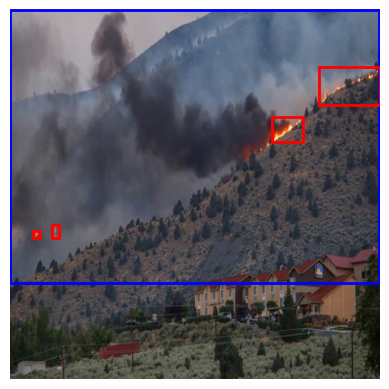

In [188]:
def predict_class(image):
    result = model.predict(image)
    boxes = result[0].boxes
    bboxes = boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    confidences = boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = boxes.cls.cpu().numpy()  # Class IDs

    label = []
    for i in range(len(bboxes)):
        ans = [class_ids[i]]
        for j in range(4):
            ans.append(bboxes[i][j])
        label.append(ans)
    return label


n = randint(0, len(test_dataset))
image, label = test_dataset[n]

prediction = predict_class(image)
show_image_with_bboxes_test(image, prediction)

In [138]:
print(bboxes)

[[     269.42       170.9      396.66      328.64]
 [      23.81           0       639.6      367.07]
 [     265.67      170.62      425.53      353.43]]
